
### Project Objective

The goal of this project is to create a web based tool that can batch analyze histopathology image patches and predict if breast cancer is present. The web app will be able to detect two forms of breast cancer:<br>

- Invasive Ductal Carcinoma (IDC)
- Metastatic Cancer

We will create two CNN models, an IDC_model and a Metastatic_model. These models will be loaded into a Tensorflowjs web app. The user will be able to select which cancer he or she wants to detect, submit many images at the same time, and get an instant prediction indicating whether or not breast cancer is present in those images.

This app will speed up a pathologist's workflow and provide diagnosis support.

To ensure privacy and patient confidentiality, all images will be processed locally and never uploaded to an external server.

We will create the models in two kernels. In part 1 we will build the IDC_model and in part 2 the Metastatic_model. In part 2 I will also cover some lessons learned while building the app.

***

All the html, css, and javascript code used to build the web app is available on Github. The technology that enables this app to work is new. Therefore, I recommend using the latest version of the Chrome browser. When using Safari for example, you may see a message indicating that the model is loading but the app may actually be frozen.

### Part 1 - IDC Model

In this section we will create the IDC_model. This model will predict whether or not Invasive Ductal Carcinoma is present. 

**Dataset**

We will use the 'Breast Histopathology Images' dataset. This dataset consists of 277,524 image patches of size 50x50 (198,738 IDC negative and 78,786 IDC positive). The images are in png format.

**Results**

Our cnn model will achieve an accuracy and F1 score that is greater than 0.85. This is based on a classification threshold of 0.5. It should be noted that the creators of the paper realting to this dataset used a threshold of 0.29.


In [1]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\user\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Number of samples we want in each class.Total images used = SAMPLE_SIZE X 2
# The minority class is class 1 with 78786 samples.

SAMPLE_SIZE = 78786

IMAGE_SIZE = 50

In [3]:
# Start of Data Preparation
### ================================================================================== ### 

### What files are available?

The images are grouped into 279 folders by patient_id. Each patient folder has two sub-folders that groups together images with the same class --> 0 or 1. There are a lot of folders to work with.

In [4]:
os.listdir('input/IDC_regular_ps50_idx5')

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262',
 '10264',
 '10268',
 '10269',
 '10272',
 '10273',
 '10274',
 '10275',
 '10276',
 '10277',
 '10278',
 '10279',
 '10282',
 '10285',
 '10286',
 '10288',
 '10290',
 '10291',
 '10292',
 '10293',
 '10295',
 '10299',
 '10300',
 '10301',
 '10302',
 '10303',
 '10304',
 '10305',
 '10306',
 '10307',
 '10308',
 '12241',
 '12242',
 '12626',
 '12748',
 '12749',
 '12750',
 '12751',
 '12752',
 '12810',
 '12811',
 '12817',
 '12818',
 '12819',
 '12820',
 '12821',
 '12822',
 '12823',
 '12824',
 '12826',
 '12867',
 '12868',
 '12869',
 '12870',
 '12871',
 '12872',
 '12873',
 '12875',
 '12876',
 '12877',
 '12878',
 '12879',
 '12880',
 '12881',
 '12882',
 '12883',
 '12884',
 '12886',
 '12890',
 '12891',
 '12892',
 '12893',
 '12894',
 '12895',
 '12896',
 '12897',
 '12898',
 '12900',
 '12901',
 '12905',
 '12906',
 '12907',
 '12908',
 '12909',
 '12910',
 '12911',
 '12929',
 '12930',
 '12931',
 '12932',
 '12933',


In [5]:
# Check the number of patient folders.

patients = os.listdir('input/IDC_regular_ps50_idx5')

len(patients)

279

### Copy all images into one directory
This will make it easier to work with this data.

In [6]:
# Create a new directory to store all available images
all_images_dir = 'all_images_dir'
#os.mkdir(all_images_dir)
#print("Checking")

In [7]:
# check that the new diectory has been created
!ls

README.md
all_images_dir
assets
base_dir
breast-cancer-analyzer-web-app -part1.ipynb
breast-cancer-analyzer-web-app-part 2.ipynb
build_dataset.ipynb
css
idc_model_v1
index.html
input
jscript
metastatic_model_v1
model.h5
part-1-breast-cancer-analyzer-web-app.ipynb
part-2-breast-cancer-analyzer-web-app.ipynb


In [35]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

# Create a list with all the patient id numbers.
# Each patient id folder has 2 sub folders --> folder 0 and folder 1

# Example:
    # '10285'
        # '0'
        # '1'

# create a list of all patient id's
patient_list = os.listdir('input/IDC_regular_ps50_idx5')

for patient in patient_list:
    
    path_0 = 'input/IDC_regular_ps50_idx5/' + str(patient) + '/0'
    path_1 = 'input/IDC_regular_ps50_idx5/' + str(patient) + '/1'


    # create a list of all files in folder 0
    file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
    file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
    for fname in file_list_0:

        # source path to image
        src = os.path.join(path_0, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


    # move the 1 images to all_images_dir
    for fname in file_list_1:

        # source path to image
        src = os.path.join(path_1, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


KeyboardInterrupt: 

In [8]:
# check how many images are in all_images_dir
# should be 277,524

# size: 2.5GB

len(os.listdir('all_images_dir'))

129133

### Create a dataframe containing all the information

In [9]:
image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

,image_id
0,10253_idx5_x1001_y1001_class0.png
1,10253_idx5_x1001_y1051_class0.png
2,10253_idx5_x1001_y1101_class0.png
3,10253_idx5_x1001_y1151_class0.png
4,10253_idx5_x1001_y1201_class0.png


In [10]:
# Define Helper Functions

# Each file name has this format:
# '14211_idx5_x2401_y1301_class1.png'

def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target

# extract the patient id

# create a new column called 'patient_id'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

,image_id,patient_id,target
0,10253_idx5_x1001_y1001_class0.png,10253,0
1,10253_idx5_x1001_y1051_class0.png,10253,0
2,10253_idx5_x1001_y1101_class0.png,10253,0
3,10253_idx5_x1001_y1151_class0.png,10253,0
4,10253_idx5_x1001_y1201_class0.png,10253,0
5,10253_idx5_x1001_y1251_class0.png,10253,0
6,10253_idx5_x1001_y1301_class0.png,10253,0
7,10253_idx5_x1001_y1351_class0.png,10253,0
8,10253_idx5_x1001_y1501_class0.png,10253,0
9,10253_idx5_x1001_y1551_class0.png,10253,0


In [11]:
df_data.shape

(129133, 3)

### Display a random sample of train images by class

In [38]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

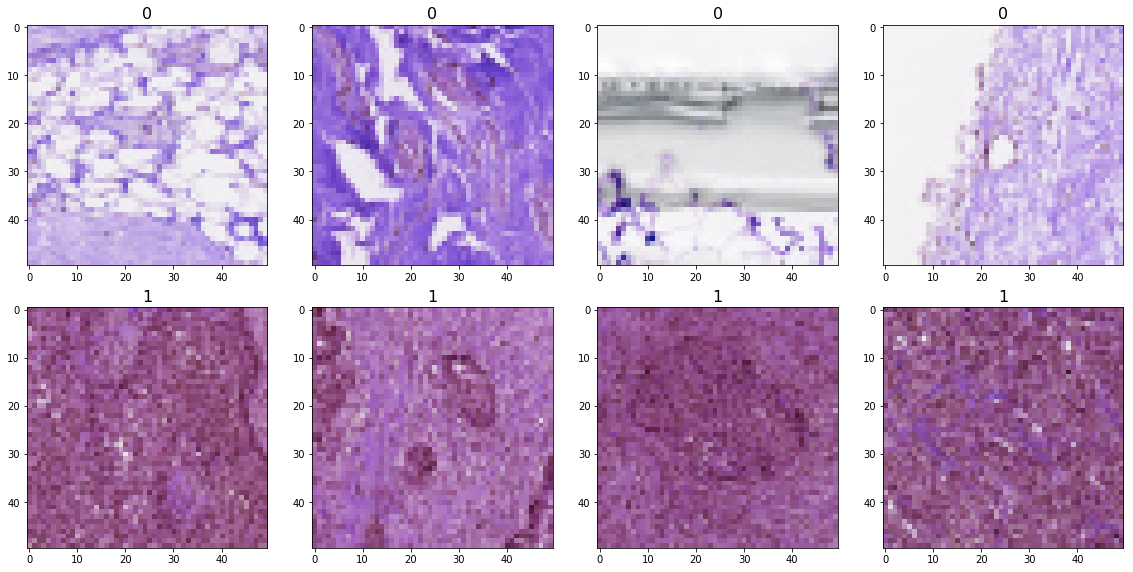

In [39]:
IMAGE_PATH = 'all_images_dir/'

draw_category_images('target',4, df_data, IMAGE_PATH)

### Balance the class distribution

In [12]:
# What is the class distribution?

df_data['target'].value_counts()

0    125242
1      3891
Name: target, dtype: int64

In [14]:
# take a sample of the majority class 0 (total = 198738)
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 78786)
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)

# concat the two dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df_data['target'].value_counts()

ValueError: Cannot take a larger sample than population when 'replace=False'

### Create the train and  val sets


In [16]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(116219, 3)
(12914, 3)


In [17]:
df_train['target'].value_counts()

0    112717
1      3502
Name: target, dtype: int64

In [18]:
df_val['target'].value_counts()

0    12525
1      389
Name: target, dtype: int64

### Create a Directory Structure

In [ ]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_idc
    # b_has_idc

# val_dir
    # a_no_idc
    # b_has_idc



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)


# create new folders inside val_dir
a_no_idc = os.path.join(val_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
os.mkdir(b_has_idc)


In [19]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_idc', 'b_has_idc']

### Transfer the images into the folders¶

In [47]:
# Set the id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    
    # source path to image
    src = os.path.join(all_images_dir, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)
    

# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    

    # source path to image
    src = os.path.join(all_images_dir, fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)

In [20]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_idc')))
print(len(os.listdir('base_dir/train_dir/b_has_idc')))

70907
70907


In [21]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_idc')))
print(len(os.listdir('base_dir/val_dir/b_has_idc')))


7879
7879


In [50]:
# End of Data Preparation
### ================================================================================== ###
# Start of Model Building

### Set Up the Generators

In [22]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'


num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [23]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 141814 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.


### Create the Model Architecture

In [24]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
__________

### Train the Model

In [54]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])


In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=60, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/60
 7709/11622 [==================>...........] - ETA: 25:01 - loss: 0.4977 - acc: 0.7639

### Evaluate the model using the val set

In [25]:
# get the metric names so we can use evaulate_generator
model.metrics_names

AttributeError: 'Sequential' object has no attribute 'metrics_names'

In [26]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

### Plot the Training Curves

In [27]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

NameError: name 'history' is not defined

### Make a prediction on the val set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

In [ ]:
predictions.shape

In [ ]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

In [ ]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

### What is the AUC Score?

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

### Create a Confusion Matrix

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Print the label associated with each class
test_gen.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_idc', 'has_idc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


### Create a Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

**Recall **= Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.


### Convert the model to from Keras to Tensorflowjs
This conversion needs to be done so that the model can be loaded into the web app.

In [ ]:
!pip install tensorflowjs

In [ ]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs_model_1/model

In [ ]:
# Delete all_images_dir and base_dir directory to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('all_images_dir')
shutil.rmtree('base_dir')

### Conclusion

In part 2 we will use the same workflow to build a model to detect metastatic cancer.

Many thanks to Paul Mooney for making the Breast Histopathology Images dataset available on Kaggle. 

See you in part 2.